In [3]:
from wingflattenfuncs import P2, P3
from wingflattenfuncs import WingShape
from wingflattenfuncs import loadwingtrimlines, trimlinestopolygons, exportpolygonsobj

import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)

trimfile = "segmentedwing.txt"
nodes, paths = loadwingtrimlines(trimfile)

# approximately flat and in metres (based around section 7) without the compression at the leading edge

No pygmsh here
Parametrization in uv:  (-1.377293405726668, 1.377293405726668) (0, 6.11206792886613)


<IPython.core.display.Javascript object>


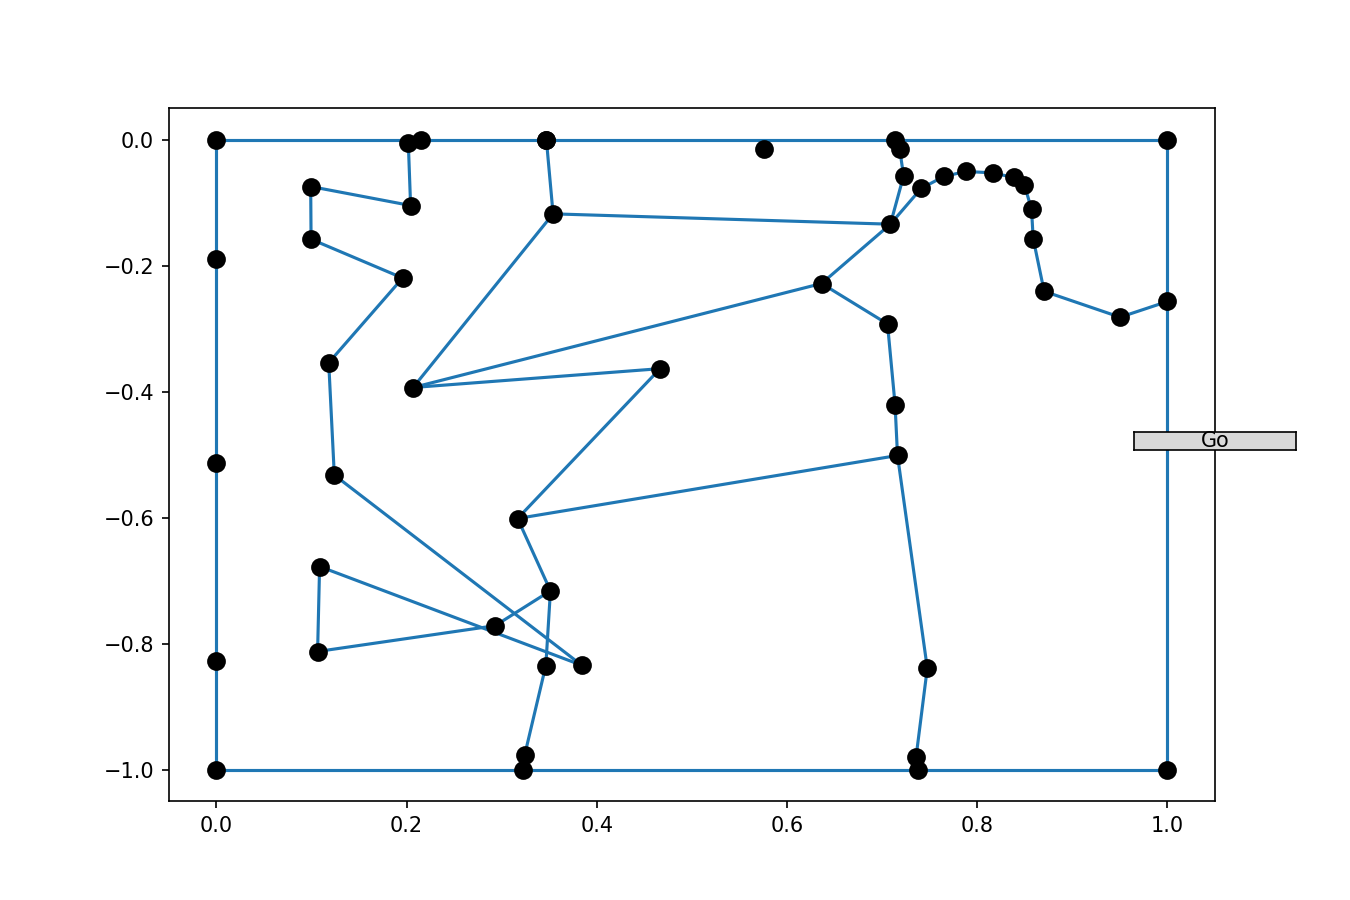

In [4]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from matplotlib.widgets import Button

rnodes = dict((nn, P2(p[1], -p[0]))  for nn, p in nodes.items())

def pointsdata():
    return zip(*rnodes.values())
def legsdata():
    return [[rnodes[paths[i]], rnodes[paths[i+1]]]  for i in range(0, len(paths), 2)]
def exchyz(p):
    return (p[0], p[2], p[1])
def points3ddata():
    res = [ ]
    for p in rnodes.values():
        res.append(exchyz(wingshape.seval((-p[1], p[0]))))
    return zip(*res)
def legs3ddata(step=0.25):
    res = [ ]
    for i in range(0, len(paths), 2):
        p0, p1 = rnodes[paths[i]], rnodes[paths[i+1]]
        n = max(1, int(math.ceil((p0 - p1).Len()/step)))
        p = wingshape.seval((-p0[1], p0[0]))
        for i in range(n):
            l = (i+1.0)/n
            pn = p0*(1-l) + p1*l
            pd = wingshape.seval((-pn[1], pn[0]))
            res.append([exchyz(p), exchyz(pd)])
            p = pd
    return res

fig = plt.figure(figsize=(9,5))
axpara = fig.add_subplot(1, 1, 1)
lc = mc.LineCollection(legsdata())
lupdater = axpara.add_collection(lc)
mupdater, = axpara.plot(*pointsdata(), color='k', linestyle='none', marker='o', markersize=8)
axpara.autoscale()

events = [ ]
nodenamedown = None

def button_press_callback(event):
    global nodenamedown
    if event.inaxes == axpara and event.button == 1:
        mp = P2(max(wingshape.vrange[0], min(wingshape.vrange[1], event.xdata)), 
                max(-wingshape.urange[1], min(-wingshape.urange[0], event.ydata)))
        l, nn = min(((mp - p).Len(), nn)  for nn, p in rnodes.items())
        if l < 0.1:
            nodenamedown = nn
        
def button_release_callback(event):
    global nodenamedown
    events.append(event)
    if event.button == 1 and nodenamedown is not None:
        nodenamedown = None
        lupdater.set_segments(legsdata())

def motion_notify_callback(event):
    if event.inaxes == axpara and nodenamedown is not None:
        rnodes[nodenamedown] = P2(event.xdata, event.ydata)
        mupdater.set_data(pointsdata())
        fig.canvas.draw_idle()
        
def buttongo(event):
    pass

def key_press_callback(self, event):
    events.append(event)
    
axres = plt.axes([0.84, 0.5, 0.12, 0.02])
bres = Button(axres, 'Go')
bres.on_clicked(buttongo)
fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)
fig.canvas.mpl_connect('key_press_event', key_press_callback)

plt.show()